### Alternative Online-Implementierung, die inkrementelle Aktualisierungen der Positionen der Zentren mit Hilfe von Mini-Chargen durchführt. Für das Lernen in großem Maßstab (sagen wir n_samples > 10k) ist miniBatchKMeans wahrscheinlich viel schneller als die Standard-Implementierung.

In [1]:
# Import necessary libraries
from copy import deepcopy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
import sklearn.datasets 
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv("../songs_25.csv")


In [3]:
df.head(2)

,Unnamed: 0,artists,song,text,number_of_tokens,Genre1,Genre2,check,POS,stemmed_text
0,0,ABBA,Me And I,sometimes when i'm mad there's a part of me t...,1551,Pop,Rock,True,mad little sad mean other rainy gloomy funny d...,sometim when i 'm mad there 's a part of me t...
1,1,ABBA,My Mama Said,tried to sneak out without saying with my lou...,1029,Pop,Rock,True,record la la la la red la la la la dead la la ...,tri to sneak out without say with my loudest ...


## Beispiel von Scikit-learn

In [28]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
               [4, 2], [4, 0], [4, 4],
               [4, 5], [0, 1], [2, 2],
               [3, 2], [5, 5], [1, -1]])

In [29]:
 # manually fit on batches
kmeans = MiniBatchKMeans(n_clusters=2,
                          random_state=0,
                          batch_size=6)
kmeans = kmeans.partial_fit(X[0:6,:])
kmeans = kmeans.partial_fit(X[6:12,:])
kmeans.cluster_centers_

array([[1, 1],
       [3, 4]])

In [30]:
kmeans.predict([[0, 0], [4, 4]])


array([0, 1])

In [31]:
# fit on the whole data
kmeans = MiniBatchKMeans(n_clusters=2,
                         random_state=0,
                         batch_size=6,
                         max_iter=10).fit(X)
kmeans.cluster_centers_

array([[3.95918367, 2.40816327],
       [1.12195122, 1.3902439 ]])

In [32]:
kmeans.predict([[0, 0], [4, 4]])

array([1, 0])

## MiniBatchKMeans auf unseren Datensatz angewendet mit PCA

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


data = df['text']
tf_idf_vectorizor = TfidfVectorizer(
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
sklearn_pca = PCA(n_components = 3)
data= sklearn_pca.fit_transform(tf_idf_array)

In [5]:
from sklearn.cluster import MiniBatchKMeans

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = MiniBatchKMeans(n_clusters=10, random_state=0, batch_size=6)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

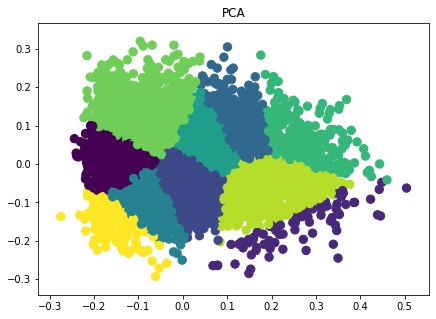

In [6]:
plt.figure(figsize=(7,5))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=70, cmap='viridis')
plt.title('PCA')
plt.savefig('K_Means/PCA_Mini-Batch_Lyrics.png', bbox_inches = "tight")

## MiniBatchKMeans auf unseren Datensatz angewendet mit t-SNE und Genre-Markern

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans

In [16]:
data = TfidfVectorizer().fit_transform(df.POS.values.astype(str))

In [17]:
X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(data)

In [18]:
perplexity = [50]
for p in perplexity:
    X_embedded = TSNE(n_components=2, perplexity=p, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6800 samples in 0.019s...
[t-SNE] Computed neighbors for 6800 samples in 1.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6800
[t-SNE] Computed conditional probabilities for sample 2000 / 6800
[t-SNE] Computed conditional probabilities for sample 3000 / 6800
[t-SNE] Computed conditional probabilities for sample 4000 / 6800
[t-SNE] Computed conditional probabilities for sample 5000 / 6800
[t-SNE] Computed conditional probabilities for sample 6000 / 6800
[t-SNE] Computed conditional probabilities for sample 6800 / 6800
[t-SNE] Mean sigma: 0.031116
[t-SNE] Computed conditional probabilities in 0.852s
[t-SNE] Iteration 50: error = 85.7521057, gradient norm = 0.0000002 (50 iterations in 5.080s)
[t-SNE] Iteration 100: error = 85.7520981, gradient norm = 0.0000115 (50 iterations in 5.294s)
[t-SNE] Iteration 150: error = 84.9241791, gradient norm = 0.0028248 (50 iterations in 6.990s)
[t-SNE] Iteration 200: error =

In [29]:
kmeans = MiniBatchKMeans(n_clusters=15, random_state=0, batch_size=6)
fitted = kmeans.fit(X_embedded)
prediction = kmeans.predict(X_embedded)

In [25]:
kmeans = KMeans(n_clusters=15, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X_embedded)
prediction = kmeans.predict(X_embedded)

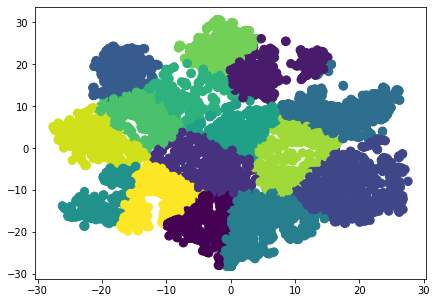

In [30]:
markers = ('o', 'v', '^', 's', 'p', '*','d', 'P', 'X')
plt.figure(figsize=(7,5))
# sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=prediction, style=df.Genre1, markers=markers, palette=sns.color_palette("hls", len(np.unique(prediction))))
# sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=prediction, palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=prediction, s=70, cmap='viridis')

# plt.title('absMiniBatch with POS')
plt.savefig('K_Means/minibatch_tsne_pos_ohne_genre.png')